Imports

In [3]:
import pandas as pd
import numpy as np
import json
import torch
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import cosine_similarity
import plotly.express as px
import plotly.io as pio
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, Dataset

## Data analysis

In [15]:
#Chargement des données
def load_dataset(file_path):
    with open(file_path, 'r') as f:
        dataset = json.load(f)
    return dataset

def load_test_set(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        test_data = f.readlines()
    return test_data
#Données originelles, celles providées par la compétition Kaggle
data_train = load_dataset("./data/train.json")
data_test = load_test_set("./data/test_shuffle.txt")
rows = []
for label, texts in data_train.items():
    for text in texts:
        rows.append({'label': label, 'texte': text})

df_train = pd.DataFrame(rows)
df_train.head()

label                                              texte
0  Politics  The mayor announced a new initiative to improv...
1  Politics  The senator is facing criticism for her stance...
2  Politics  The upcoming election has sparked intense deba...
3    Health  Regular exercise and a balanced diet are key t...
4    Health  The World Health Organization has issued new g...

In [11]:
print(f"Nombre de données train: {len(df_train)}")
print(f"Listes des classes : {df_train.label.unique()}")
print(f"Nombre de classes : {len(df_train.label.unique())}")
print(f"Nombre de donnnées test : {len(data_test)}")

Nombre de données train: 36
Listes des classes : ['Politics' 'Health' 'Finance' 'Travel' 'Food' 'Education' 'Environment'
 'Fashion' 'Science' 'Sports' 'Technology' 'Entertainment']
Nombre de classes : 12
Nombre de donnnées test : 1140


<AxesSubplot: title={'center': 'Répartition des classes'}, xlabel='label'>

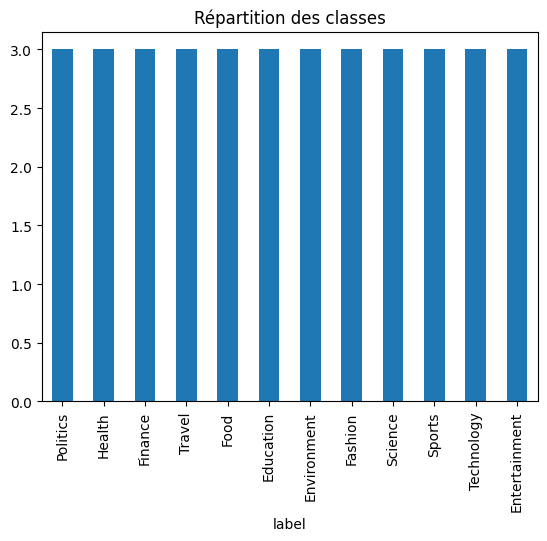

In [3]:
#Class repartition
df_train['label'].value_counts().plot(kind='bar', title='Répartition des classes')



The distribution of data is well balanced, with 3 data per class. However, we're beginning to see a problem: the lack of data for each class.

Let's start by seeing if the frequency of certain words appears for each class.


In [13]:
pio.renderers.default = 'notebook'
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

# We plot the top 20 words
common_words = get_top_n_words(df_train['texte'], 20)
df1 = pd.DataFrame(common_words, columns=['Text', 'Count'])
fig = px.bar(df1, x='Text', y='Count', title='Top 20 des mots utilisés dans data set', 
             labels={'Count': 'Count', 'Text': 'Word'}, 
             color_discrete_sequence=['blue'])
fig.show()

# Now we will plot the top 20 words for each class. 
# We will use the same function as before but we will filter the data for each class.
common_words_per_class = {}
for label in df_train['label'].unique():
    df2 = df_train[df_train['label'] == label]
    common_words = get_top_n_words(df2['texte'], 20)
    df3 = pd.DataFrame(common_words, columns = ['Text', 'Count'])
    common_words_per_class[label] = df3

for label, df in common_words_per_class.items():
    fig = px.bar(df, x='Text', y='Count', title=f'Top 20 des mots utilisés dans la classe {label}',
                labels={'Count': 'Count', 'Text': 'Word'}, color_discrete_sequence=['blue'])
    fig.show()

As we can see, even if some words represent the class they're in fairly well, we can already assume that their frequency is too low to hope to build an efficient from-scratch model. However, the presence of certain very representative words ("movie" for the "Entertainment" class, "climate" for the "Environnement" class...) may appear to be a good basis for the construction of new phrases. However, these are only hypotheses at this stage.

#### Some statistics

In [4]:
print(f"The mean of size of the sentences : {df_train['texte'].apply(lambda x: len(x.split())).mean()}.")

The mean of size of the sentences : 11.083333333333334.


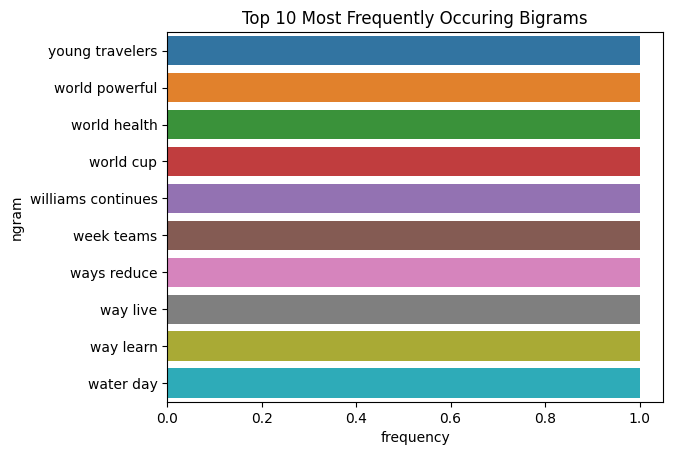

In [5]:
cv = CountVectorizer(stop_words='english', ngram_range=(2,2))
bigrams = cv.fit_transform(df_train['texte'])
count_values = bigrams.toarray().sum(axis=0)
ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv.vocabulary_.items()], reverse = True))
ngram_freq.columns = ["frequency", "ngram"]
sns.barplot(x=ngram_freq['frequency'][:10], y=ngram_freq['ngram'][:10])
plt.title('Top 10 Most Frequently Occuring Bigrams')
plt.show()

In [7]:
from torchtext.vocab import FastText
import preprocessing

df_train['texte'] = df_train['texte'].apply(preprocessing.clean_text)

pretrained_vectors = FastText(language='en',cache = "C:/Users/bilel/Documents/Centrale 3A/NLP/NLP_CS_Student_2024/labs/lab3-4/.vector_cache")

In [8]:
sentence1 = df_train[df_train['label'] == 'Health']['texte'].iloc[0]
sentence2 = df_train[df_train['label'] == 'Food']['texte'].iloc[1] 

words1 = sentence1.split()
words1 = [word for word in words1]

words2 = sentence2.split()
words2 = [word for word in words2]

words = words1 + words2

vectors = [pretrained_vectors[word].numpy() for word in words]
vectors = np.array(vectors)

tsne = TSNE(n_components=3, perplexity=10, random_state=0)
vectors_3d = tsne.fit_transform(vectors)

fig = px.scatter_3d(x=vectors_3d[:, 0], y=vectors_3d[:, 1], z=vectors_3d[:, 2], text=words)
fig.update_traces(textposition='top center')
fig.update_layout(height=800, width=800, title_text='Embeddings des mots dans les phrases')
fig.show()

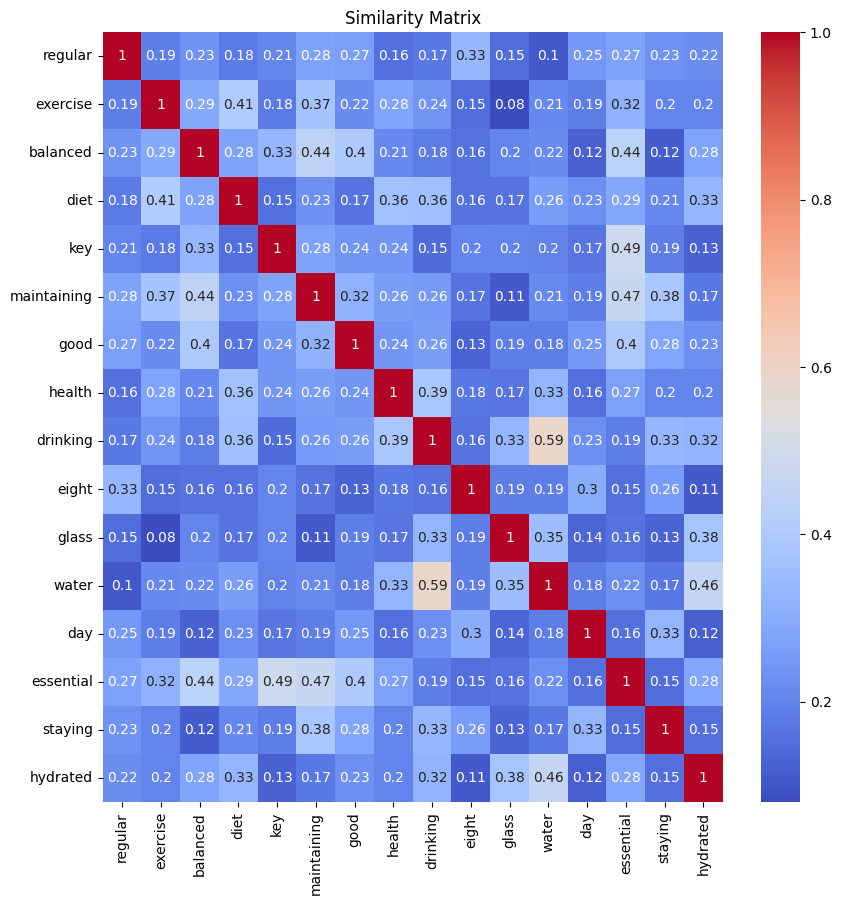

In [9]:
similarity = cosine_similarity(vectors)
similarity = pd.DataFrame(similarity, columns=words, index=words)
# Let's plot the similarity matrix
plt.figure(figsize=(10, 10))
sns.heatmap(similarity, annot=True, cmap='coolwarm')
plt.title('Similarity Matrix')
plt.show()

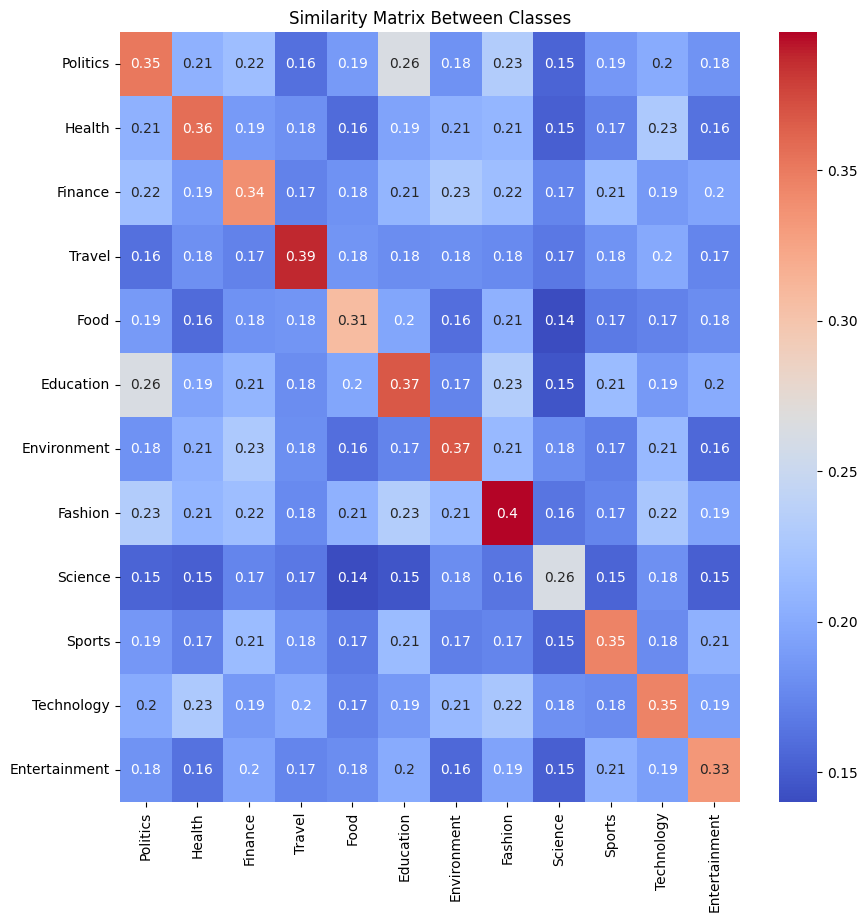

In [10]:
classes = df_train['label'].unique()
similarity_classes = np.zeros((len(classes), len(classes)))
for i, class1 in enumerate(classes):
    for j, class2 in enumerate(classes):
        words1 = df_train[df_train['label'] == class1]['texte'].iloc[0].split()
        words2 = df_train[df_train['label'] == class2]['texte'].iloc[0].split()
        vectors1 = [pretrained_vectors[word].numpy() for word in words1]
        vectors2 = [pretrained_vectors[word].numpy() for word in words2]
        similarity = cosine_similarity(vectors1, vectors2)
        similarity_classes[i, j] = similarity.mean()

similarity_classes = pd.DataFrame(similarity_classes, columns=classes, index=classes)
plt.figure(figsize=(10, 10))
sns.heatmap(similarity_classes, annot=True, cmap='coolwarm')
plt.title('Similarity Matrix Between Classes')
plt.show()

###  Implementing a first model: Bag of words

In [10]:
def load_test_set(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        test_data = f.readlines()
    return test_data

labelised = True

if(labelised):
    data_test = load_test_set("./data/test_label.txt")
    rows = []
    for data in data_test:
        label, text = data.split(',',1)
        rows.append({'label': label, 'text': text})
else:
    data_test = load_test_set("test_shuffle.txt")
    rows = []
    for data in data_test:
        rows.append({'text': data})

df_test = pd.DataFrame(rows)
df_train = pd.read_csv('./data/train.csv')
df_train = df_train.sample(frac=1, random_state=42)
df_train.reset_index(drop=True, inplace=True)
df_train

label                                               text
0         Education  Its goal is to overcome the challenges posed b...
1           Fashion  Although the fashion industry developed first ...
2           Science  This theory uses only three of Aristotle's fou...
3           Fashion  Fashion trends\nMain article: Fashion trend\nS...
4     Entertainment  Psychologists say the function of media entert...
...             ...                                                ...
5409       Politics  However, many political parties have no ideolo...
5410         Travel  Since every country imposes different travel r...
5411         Travel  Please help improve this section by adding cit...
5412         Travel  This issue cannot be understood without the fi...
5413  Entertainment  They presented conquered peoples and nations t...

[5414 rows x 2 columns]

In [11]:
X_train = df_train['text']
y_train = df_train['label']
X_test = df_test['text']
y_test = df_test['label']

#Vectorisation du texte
vectorizer = CountVectorizer(stop_words='english')
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

#Multinomial Naïve Bayes for classification
classifier = MultinomialNB()
classifier.fit(X_train_vectorized, y_train)

predictions = classifier.predict(X_test_vectorized)

accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

Accuracy: 0.6736842105263158


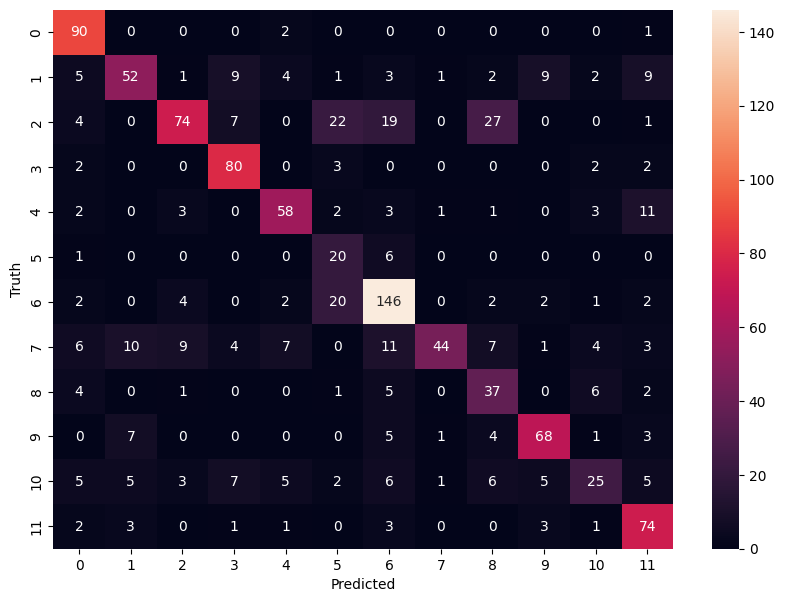

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

### A second model: Bert fine tuning, a more precise model

In [19]:
#Chargement des données
def load_dataset(file_path):
    with open(file_path, 'r') as f:
        dataset = json.load(f)
    return dataset

def load_test_set(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        test_data = f.readlines()
    return test_data
#Données originelles, celles providées par la compétition Kaggle
data_train = load_dataset("./data/train.json")
data_test = load_test_set("./data/test_shuffle.txt")
rows = []
for label, texts in data_train.items():
    for text in texts:
        rows.append({'label': label, 'texte': text})

df_train = pd.DataFrame(rows)
df_train.head()

label                                              texte
0  Politics  The mayor announced a new initiative to improv...
1  Politics  The senator is facing criticism for her stance...
2  Politics  The upcoming election has sparked intense deba...
3    Health  Regular exercise and a balanced diet are key t...
4    Health  The World Health Organization has issued new g...

In [20]:
le = LabelEncoder()
df_train['label'] = le.fit_transform(df_train['label'])
df_test['label'] = le.transform(df_test['label'])


In [21]:
import torch
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from preprocessing import clean_text

#Now we will train a BERT model on the augmented data using the sentence transformer embeddings

df_train_aug = pd.read_csv('train_augmented_3.csv')

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

class CustomDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        text = self.data.iloc[idx]['text']
        label = self.data.iloc[idx]['label']
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

MAX_LEN = 15
BATCH_SIZE = 8
EPOCHS = 15

train_dataset = CustomDataset(df_train_aug, tokenizer, MAX_LEN)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=12)

model.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))


optimizer = AdamW(model.parameters(), lr=2e-5)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\bilel\anaconda3\envs\DeepL\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


#### Training

In [22]:
losses = []
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for batch in train_dataloader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
        attention_mask = batch['attention_mask'].to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
        labels = batch['label'].to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    avg_train_loss = total_loss / len(train_dataloader)
    losses.append(avg_train_loss)
    print(f'Epoch {epoch+1}/{EPOCHS}')
    print(f'Training loss: {avg_train_loss:.4f}')

Epoch 1/15
Training loss: 2.5040
Epoch 2/15
Training loss: 2.2998
Epoch 3/15
Training loss: 2.0334
Epoch 4/15
Training loss: 1.7250
Epoch 5/15
Training loss: 1.4179
Epoch 6/15
Training loss: 1.1679
Epoch 7/15
Training loss: 0.8962
Epoch 8/15
Training loss: 0.6636
Epoch 9/15
Training loss: 0.5005
Epoch 10/15
Training loss: 0.3687
Epoch 11/15
Training loss: 0.2799
Epoch 12/15
Training loss: 0.2213
Epoch 13/15
Training loss: 0.1761
Epoch 14/15
Training loss: 0.1515
Epoch 15/15
Training loss: 0.1296


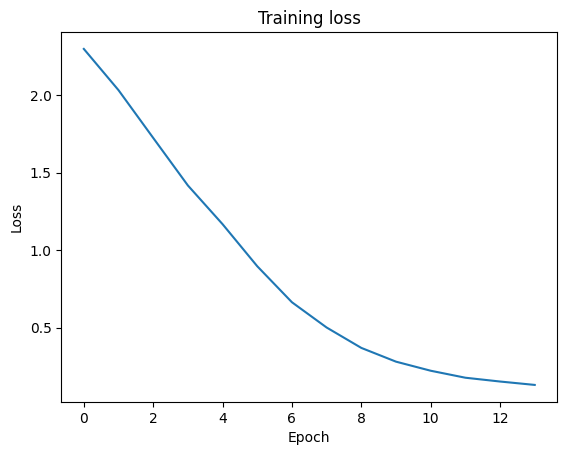

In [23]:
plt.plot(losses[1::])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training loss')
plt.show()

#### Evaluation

In [24]:
df_test['text'] = df_test['text'].apply(clean_text)
test_dataset = CustomDataset(df_test, tokenizer, MAX_LEN)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
model.eval()
predictions = []
true_labels = []
for batch in test_dataloader:
    input_ids = batch['input_ids'].to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
    attention_mask = batch['attention_mask'].to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
    labels = batch['label']
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    predictions.extend(torch.argmax(logits, dim=1).tolist())
    true_labels.extend(labels.tolist())

accuracy = accuracy_score(true_labels, predictions)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.7228


### Third model : Wikidata, a richer dataset

Data loading

In [23]:
def load_dataset(file_path):
    with open(file_path, 'r') as f:
        dataset = json.load(f)
    return dataset

def load_test_set(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        test_data = f.readlines()
    return test_data


data_train = load_dataset("./data/train.json")
data_test = load_test_set("./data/test_shuffle.txt")

rows = []
for label, texts in data_train.items():
    for text in texts:
        rows.append({'label': label, 'text': text})

df_train = pd.DataFrame(rows)

labelised = True

if(labelised):
    data_test = load_test_set("./data/test_label.txt")
    rows = []
    for data in data_test:
        label, text = data.split(',',1)
        rows.append({'label': label, 'text': text})
else:
    data_test = load_test_set("./data/test_shuffle.txt")
    rows = []
    for data in data_test:
        rows.append({'text': data})

df_test = pd.DataFrame(rows)
df_test.head()

label                                               text
0     Politics   The role of credit scores in lending decision...
1  Environment   The impact of overpopulation on the environme...
2      Science   The importance of the scientific method in co...
3      Finance   The startup accelerator provides funding and ...
4   Technology   The benefits of biomimicry are many, includin...

In [24]:
#Label encoding
le = LabelEncoder()

df_train['label'] = le.fit_transform(df_train['label'])
df_test['label'] = le.transform(df_test['label'])
df_wiki = pd.read_csv('./data/wiki_data.csv')
df_wiki['label'] = le.transform(df_wiki['label'])

df_wiki.head()


label                                               text
0      0  Photo of primary school children sitting in an...
1      0  Education is the transmission of knowledge, sk...
2      0  Formal education occurs within a structured in...
3      0  Non-formal education also follows a structured...
4      0  Formal and non-formal education are categorize...

In [35]:
#Data augmentation with wiki data
df_train_aug = pd.read_csv('train_augmented_M.csv')

#Computing and displaying average text length
print(df_train_aug['text'].apply(lambda x: len(x.split())).mean())
print(df_wiki['text'].apply(lambda x: len(x.split())).mean())

11.954070407040705
24.12052246190382


In [36]:
df_train = pd.concat([df_train_aug, df_wiki], ignore_index=True)
df_train

label                                               text
0         7  The mayor announced a new initiative to improv...
1         7  The senator is facing criticism for her stance...
2         7  The upcoming election has sparked intense deba...
3         6  Regular exercise and a balanced diet are key t...
4         6  The World Health Organization has issued new g...
...     ...                                                ...
8684     11  : 23  There is now broad consensus that touris...
8685     11  The New York Times recently described the Gran...
8686     11  It includes a set of sub-disciplines, and glob...
8687     11  Travel to Mount Everest, the Amazon rainforest...
8688     11  It helps educate the traveller; provides funds...

[8689 rows x 2 columns]

Model creation

In [37]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

#Custom data set to fit BERT requirements
class CustomDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        text = self.data.iloc[idx]['text']
        label = self.data.iloc[idx]['label']
        
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [38]:
#Training parameters
MAX_LEN = 30
BATCH_SIZE = 32
EPOCHS = 10

In [39]:

train_dataset = CustomDataset(df_train, tokenizer, MAX_LEN)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=12)
model.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
optimizer = AdamW(model.parameters(), lr=1e-5)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\bilel\anaconda3\envs\DeepL\lib\site-packages\transformers\optimization.py:429: FutureWarning:

This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning



Training

In [40]:
#Training loop

losses = []
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for batch in train_dataloader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
        attention_mask = batch['attention_mask'].to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
        labels = batch['label'].to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    avg_train_loss = total_loss / len(train_dataloader)
    losses.append(avg_train_loss)
    print(f'Epoch {epoch+1}/{EPOCHS}')
    print(f'Training loss: {avg_train_loss:.4f}')

Epoch 1/10
Training loss: 1.2989
Epoch 2/10
Training loss: 0.3115
Epoch 3/10
Training loss: 0.1700
Epoch 4/10
Training loss: 0.1048
Epoch 5/10
Training loss: 0.0659
Epoch 6/10
Training loss: 0.0404
Epoch 7/10
Training loss: 0.0285
Epoch 8/10
Training loss: 0.0196
Epoch 9/10
Training loss: 0.0149
Epoch 10/10
Training loss: 0.0151


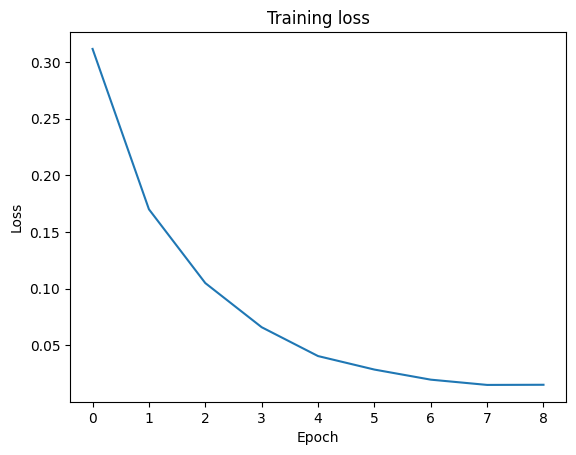

In [41]:
#Training loss plot
plt.plot(losses[1::])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training loss')
plt.show()

Evaluation

In [42]:
#Accuracy
test_dataset = CustomDataset(df_test, tokenizer, MAX_LEN)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
model.eval()
predictions = []
true_labels = []
for batch in test_dataloader:
    input_ids = batch['input_ids'].to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
    attention_mask = batch['attention_mask'].to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
    labels = batch['label']
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    predictions.extend(torch.argmax(logits, dim=1).tolist())
    true_labels.extend(labels.tolist())

accuracy = accuracy_score(true_labels, predictions)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.7342


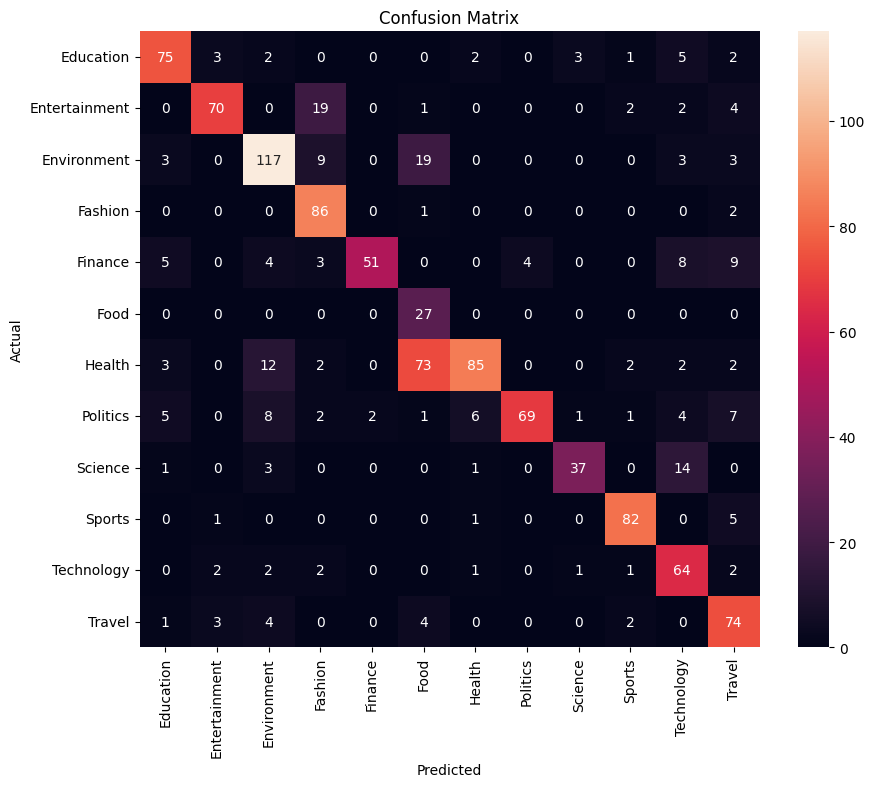

In [43]:
#Confusion matrix

cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

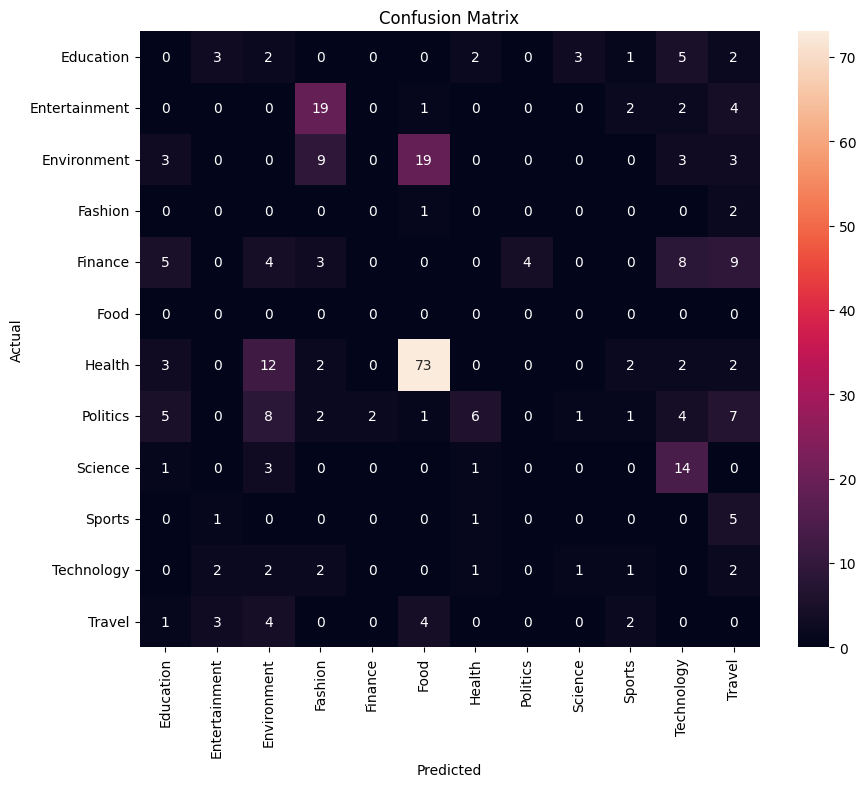

In [44]:
#Confusion matrix with zeros on the diagonal (visual only)


def copy_matrix_with_zero_diagonal(matrix):
    copied_matrix = np.copy(matrix)
    
    rows, cols = copied_matrix.shape
    
    for i in range(min(rows, cols)):
        copied_matrix[i, i] = 0
    
    return copied_matrix
cm_d = copy_matrix_with_zero_diagonal(cm)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_d, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### Fourth method: The ensemble method a more accurate seperation ?

In [28]:
from sentence_transformers import SentenceTransformer

df_train_aug = pd.read_csv('train_augmented_100.csv')
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

train_embeddings = model.encode(df_train_aug['text'], show_progress_bar=True)
test_embeddings = model.encode(df_test['text'], show_progress_bar=True)

train_embeddings = torch.tensor(train_embeddings)
test_embeddings = torch.tensor(test_embeddings)

torch.save(train_embeddings, 'train_embeddings_100_entier.pt')
torch.save(test_embeddings, 'test_embeddings_100_entier.pt')

Batches:   0%|          | 0/114 [00:00<?, ?it/s]

Batches:   0%|          | 0/36 [00:00<?, ?it/s]

Let's first see if can vizualize the fact that somme classes are too hard to split

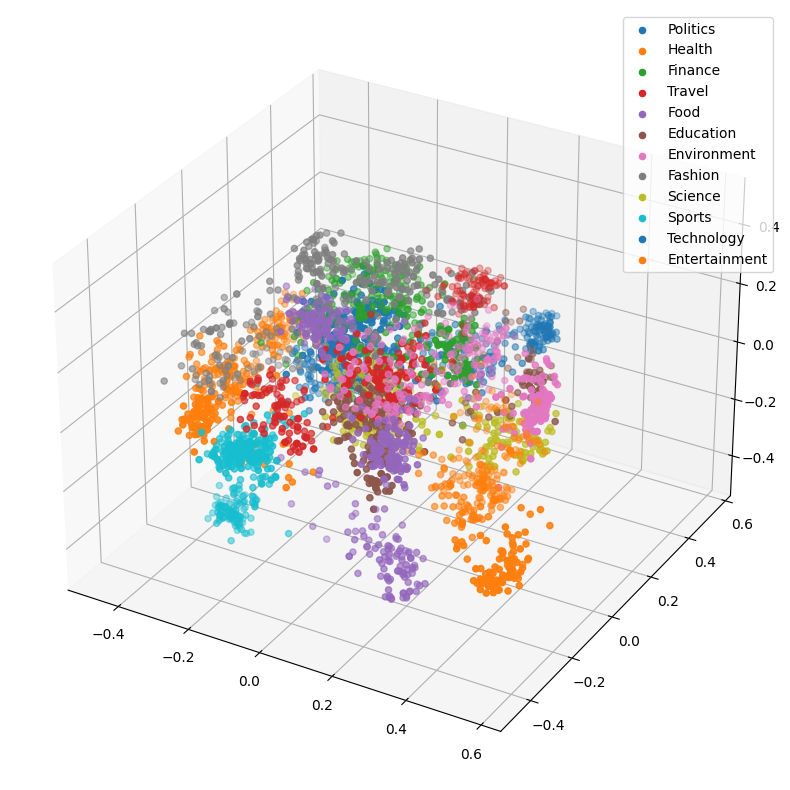

In [29]:
train_embeddings = torch.load('train_embeddings_100_entier.pt')
test_embeddings = torch.load('test_embeddings_100_entier.pt')
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=3)
train_embeddings_pca = pca.fit_transform(train_embeddings)
test_embeddings_pca = pca.transform(test_embeddings)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
for label in df_train_aug['label'].unique():
    indices = df_train_aug['label'] == label
    ax.scatter(train_embeddings_pca[indices, 0], train_embeddings_pca[indices, 1], train_embeddings_pca[indices, 2], label=le.inverse_transform([label])[0])
ax.legend()
plt.show()

### Ensemble model

SGDClassifier trained
LogisticRegression trained
RandomForestClassifier trained
SVC trained


C:\Users\bilel\AppData\Local\Temp\ipykernel_2340\625305225.py:33: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ensemble_predictions = mode(list_predictions)[0][0]


Ensemble
              precision    recall  f1-score   support

           0       0.73      0.89      0.81        93
           1       0.76      0.76      0.76        98
           2       0.80      0.85      0.82       154
           3       0.74      0.90      0.81        89
           4       0.60      0.76      0.67        84
           5       0.39      0.52      0.44        27
           6       0.87      0.78      0.82       181
           7       0.82      0.68      0.74       106
           8       0.56      0.77      0.65        56
           9       0.88      0.58      0.70        89
          10       0.80      0.44      0.57        75
          11       0.76      0.74      0.75        88

    accuracy                           0.75      1140
   macro avg       0.73      0.72      0.71      1140
weighted avg       0.77      0.75      0.75      1140

Accuracy: 0.7482456140350877


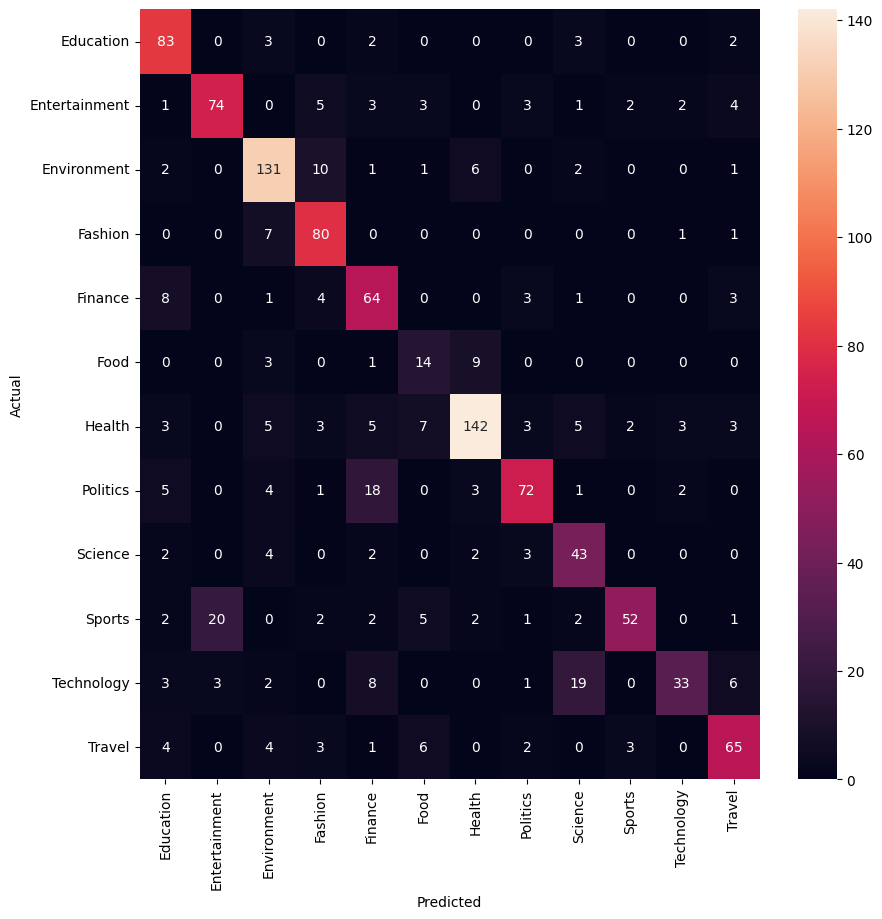

In [33]:
train_embeddings = torch.load('train_embeddings_100_entier.pt')
test_embeddings = torch.load('test_embeddings_100_entier.pt')
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from scipy.stats import mode


#Let's give more weights to class 5  and the same to the other 11 classes
weights = {i: 1 for i in range(12)}
weights[5] = 2
list_classifiers = [SGDClassifier(loss='hinge', penalty='l2',alpha=0.005, random_state=42,class_weight=weights),
                    LogisticRegression(max_iter=1000, random_state=42,class_weight=weights),
                    RandomForestClassifier(random_state=42, class_weight=weights),
                    SVC(probability=True, random_state=42, class_weight=weights),]



for classifier in list_classifiers:
    classifier.fit(train_embeddings, df_train_aug['label'])
    print(f'{classifier.__class__.__name__} trained')


list_predictions = []
for classifier in list_classifiers:
    predictions = classifier.predict(test_embeddings)
    list_predictions.append(predictions)

ensemble_predictions = mode(list_predictions)[0][0]
print('Ensemble')
print(classification_report(df_test['label'], ensemble_predictions))
print(f"Accuracy: {accuracy_score(df_test['label'], ensemble_predictions)}")


cm = confusion_matrix(df_test['label'], ensemble_predictions)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
#Results soumission
df_test['label'] = predictions
df_test['label'] = le.inverse_transform(df_test['label'])
df_test.head()
df_test.drop('text', axis=1, inplace=True)
df_test['ID'] = df_test.index
df_test = df_test[['ID', 'label']]
df_test.to_csv('submission_test.csv', index=False)